# Final Preprocessing for Analysis

In [1]:
import numpy as np
import ast
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
%matplotlib inline

## Load data

In [2]:
df = pd.read_json("data_clean.json")

## Drop all projects without skill 

In [4]:
# Count number of projects with missing skill
df.skills.isna().sum()

127737

In [5]:
df = df[df['skills'].notna()]

## Add Skill score

In [7]:
skill_scores = pd.read_csv("skill_scores.csv")

In [8]:
df = df.merge(skill_scores, how='left', on="category_2")

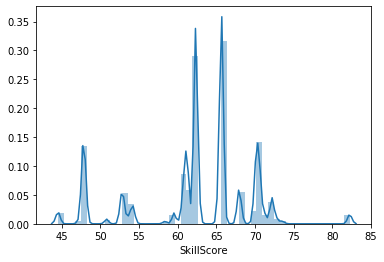

In [9]:
sns.distplot(df.SkillScore)

### Add skill categories

In [10]:
df["skill_level"] = np.nan

In [11]:
df["SkillScore"] = df["SkillScore"].astype(float)

In [12]:
# Function to assign skill categories
def assign_cat(df):
    for i in df.index:
        if df.loc[i,"SkillScore"] < 55:
            df.loc[i,"skill_level"] = "low"
        elif df.loc[i,"SkillScore"] < 65 and df.loc[i,"SkillScore"] > 55:
            df.loc[i,"skill_level"] = "medium"
        elif df.loc[i,"SkillScore"] >= 65:
            df.loc[i,"skill_level"] = "high"
    return df

In [13]:
# function to multiprocess
from multiprocessing import  Pool

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [14]:
# Assign categories
df = parallelize_dataframe(df,assign_cat)

In [15]:
df["skill_level"].unique()

array(['high', 'low', 'medium', nan], dtype=object)

In [16]:
df["skill_level"].value_counts(dropna=False)

high      219806
medium    162617
low        91035
NaN        70392
Name: skill_level, dtype: int64

## Exclude extreme values (projects with extreme hourly wages)

In [17]:
# Exclude extreme values
print('% of projects with hourly rate above $150:',df[df.rate > 150].shape[0]/df.shape[0])
print('% of projects with hourly rate zero:', df[df.rate == 0].shape[0]/df.shape[0])

df = df[df.rate < 150]
df = df[df.rate > 0]
print('New number of observations:', df.shape[0])

% of projects with hourly rate above $150: 0.0
% of projects with hourly rate zero: 0.0
New number of observations: 543850


In [22]:
# Save csv just in case
df.to_csv("backup.csv")

## Transfrom skill column

In [21]:
df.reset_index(inplace=True)

In [18]:
# Regex test
if re.search(r",", df.skills[0]):
    print('success')

success


In [19]:
# transform str list into list

def transform_list(df):
    for index, row in df.skills.dropna().iteritems():

        if re.search(r",", df.skills[index]):
            try:
                df.skills[index] = ast.literal_eval(df.skills[index]) 
            except:
                #print('Error', index, row)
                continue

        else:
            #print(index,row)
            continue
    return df

In [20]:
# function to multiprocess
from multiprocessing import  Pool

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [21]:
df_clean = parallelize_dataframe(df,transform_list)

/Users/oleteutloff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/oleteutloff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/oleteutloff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/oleteutloff/opt/anaconda3/lib/python

## Delete all columns that are not required

In [26]:
del df_clean['date']
del df_clean['index']
del df_clean['description']
del df_clean['title']
del df_clean['worker_ID']
del df_clean['op_engagement']
del df_clean['engagement_weeks']
del df_clean['op_pref_english_skill']
del df_clean['employer_country']
del df_clean['employer_city']
del df_clean['job_type']
#del df_clean['inflation_yearly']
#del df_clean['real_rate_yearly']

In [28]:
# save as json
df_clean.to_json("data_clean1.json")

## Join dataframes together

In [30]:
data_clean1 = pd.read_json("data_clean1.json")
data_clean2 = pd.read_json("data_clean2.json")
data_clean3 = pd.read_json("data_clean3.json")

In [31]:
combined_df = pd.concat([data_clean1,data_clean2,data_clean3])
combined_df.reset_index(inplace=True)
del df_clean['index']

## Inflation adjustment of wages

In [ ]:
import cpi
df["date_3"] = pd.to_datetime(df.date_2)
df["year"] = df['date_3'].dt.year
df["new_year"] = np.where(df["year"]==2019,2018,df["year"])
df['adj_rate'] = df.apply(lambda x: cpi.inflate(x.rate, x.new_year, to=2016), axis=1)
df['adj_rate'] = np.around(df['adj_rate'],decimals=1)

In [ ]:
# Exclude 2015
df = df.loc[df['year'] != 2015]

In [ ]:
# drop unnecessary columns

del df["date_3"]
del df["year"]
del df["new_year"]

### Save data

In [38]:
combined_df.to_json("full_data.json")

# Not required

In [ ]:
# Assign unique ID to each project
df.reset_index(inplace = True)
df.rename(columns = {"index":"project_id"}, inplace = True)